<b>Neural Text Recognition</b>

Text recognition of text in generated images with noise using an Encoder/Decoder NN architecture. The system uses an generator from Ziqing Yang’s work in the repository <a href=”https://github.com/airaria/CaptchaRecognition”>CaptchaRecognition</a>to create images from text strings. The text strings (targets) are extracted from an English/German translation set.

The dataset can be downloaded from <a href="http://www.manythings.org/anki/">Tatoeba Project: Tab-delimited Bilingual Sentence Pairs</a>. The file is names "deu-eng.zip" (German-English) and contains deu.txt, which needs to be converted to a tsv and the english/german columns need to be swapped. The file should be called "eng-ger-data.tsv" and located in ".data" or the reference below in the torch TabularDataset statement needs to be changed.

The implementation in parts follows Keon's <a href="https://github.com/keon/seq2seq/blob/master/model.py">"Minimal Seq2Seq model with Attention for Neural Machine Translation in PyTorch"</a>.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display

from tqdm import tqdm_notebook

import os
import random
import numpy as np
import math

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms

# used to suppress "UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad()"
import warnings
warnings.filterwarnings("ignore" ,category=FutureWarning)

from utils import *

%load_ext watermark
%watermark -a "tb" -d -v -m -p sys,numpy,pandas,sklearn,torch,IPython
gpu_stat()

tb 2018-09-28 

CPython 3.6.4
IPython 6.2.1

sys 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.14.2
pandas 0.22.0
sklearn 0.19.2
torch 0.4.0a0+9692519
IPython 6.2.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.5.0
machine    : x86_64
processor  : i386
CPU cores  : 24
interpreter: 64bit

GPU Name: TITAN Xp
GPU Memory: 12.0GB
CUDA Version: (9, 1, 0)
GPU Free/Total Memory: 88%


In [2]:
#torch.cuda.is_available = lambda : False
#torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True

In [3]:
seed = 0
np.random.seed(0)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [4]:
H = HYPERPARAMETERS({
    'BATCH_SIZE'          : 64,
    'HIDDEN_SIZE'         : 256,
    'NUM_RNN_LAYERS'      : 2,
    'DROPOUT'             : 0.5,
    'LR'                  : 0.0003,
    'MAX_GRAD_NORM'       : 5.,
    'NUM_EPOCHS'          : 50,
    'USE_CUDA'            : torch.cuda.is_available(),
})

In [5]:
def visualize_data(dataset, img, tokens, text=None, figsize=(18,14)):
    img = img.cpu().numpy().transpose(1,2,0)
    txt = ' '.join([dataset.vocab.idx2word[str(tok.item())] for tok in tokens.cpu().numpy()])

    title = txt + '/' + text if not text is None else txt
    
    plt.figure(figsize=figsize)
    plt.title(txt)
    plt.imshow(img)

In [6]:
class Vocabulary(object):
    def __init__(self, root_dir='data/NHTR/'):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.path = os.path.join(root_dir, 'vocab.json')
        
        self.add('<PAD>')
        self.add('<SOS>')
        self.add('<EOS>')
        self.add('<UNK>')

    def add(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<UNK>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)
    
    def dump(self):
        data = {'idx': self.idx, 'word2idx':self.word2idx, 'idx2word':self.idx2word}
        with open(self.path, "w") as fd:
            json.dump(data, fd)

    def load(self):
        with open(self.path, "r") as fd:
            data = json.load(fd)
            self.idx = data['idx']
            self.word2idx = data['word2idx']            
            self.idx2word = data['idx2word']

In [7]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import spacy
import shutil
import json

class NHTR_Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir='data/NHTR/', transform=None, max_data_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.max_data_size = max_data_size
        
        self.annotations = []
        self.tokens = []
        self.max_token_length = 0
        
        self.vocab = Vocabulary(root_dir=self.root_dir)
        
    def __len__(self):
        return len(self.annotations) if self.max_data_size is None else self.max_data_size
    
    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        
        image = Image.open(annotation['img_path']).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
            
        target = annotation['tokens']
        
        return image, torch.LongTensor(target)
        
    def load(self):
        path = os.path.join(self.root_dir, 'annotations.json')

        with open(path, "r") as fd:
             data = json.load(fd)
                
        self.annotations = data['annotations']
        self.max_token_length = data['max_token_length']
                        
        self.vocab.load()     
    
    def generate_image(self, txt, width, height, fonts):
        img_gen = ImageCaptcha(fonts=fonts, width=width, height=height)
        captcha = img_gen.generate(txt)
        img = Image.open(captcha)
        return img

    def generate(self, text_file="./data/eng-ger-data.tsv", data_size = 1000, image_width = 512, image_height = 48,
                                                            fonts=['fonts/YaHeiConsolas.ttf']):
        spacy_en = spacy.load('en')

        texts = []
        with open(text_file,'r') as tsvin:
            tsvin = csv.reader(tsvin, delimiter='\t')
            for row in tsvin:
                texts.append(row[0])

        if os.path.exists(self.root_dir):
            shutil.rmtree(self.root_dir)
        os.makedirs(os.path.join(self.root_dir, 'images'))

        annotations = []
        max_token_length = 0
        for idx, txt in enumerate(texts):
            if idx > data_size-1:
                break
            img = self.generate_image(txt, image_width, image_height, fonts)
            path = os.path.join(self.root_dir, 'images', 'img{:08d}.png'.format((idx)))
            img.save(path)

            tokens = []
            tokens.append(self.vocab.word2idx['<SOS>'])
            for token in spacy_en.tokenizer( str(txt).lower() ):
                word = token.text
                self.vocab.add(word)
                tokens.append(self.vocab.word2idx[word])
            tokens.append(self.vocab.word2idx['<EOS>'])
            
            if len(tokens) > max_token_length:
                max_token_length = len(tokens)
 
            annotations.append({'img_path':path, 'target':txt, 'tokens': tokens})

        path = os.path.join(self.root_dir, 'annotations.json')
        with open(path, "w") as fd:
            json.dump({'max_token_length':max_token_length, 'annotations':annotations}, fd)

        self.vocab.dump()  
        
    def get_vocabular(self):
        return self.vocab

In [8]:
# Generate a new dataset
from captcha.image import ImageCaptcha

from PIL import Image

import csv

dataset = NHTR_Dataset(root_dir='data/NHTR/')

# Note that teh generation will take some time - comment the following statement out once daataset has been generated, 
# i.e. if run multiple times to validate hyperparamaters
dataset.generate(text_file="./data/eng-ger-data.tsv", data_size = 60000, image_width = 512, image_height = 48,
                                                        fonts=['fonts/YaHeiConsolas.ttf'])
dataset.load()

print("Dataset Size:", len(dataset))
print("Max Token Length:", dataset.max_token_length)
print("Vocabulary Length:", len(dataset.get_vocabular()))

Dataset Size: 60000
Max Token Length: 12
Vocabulary Length: 7091


In [9]:
transform = transforms.Compose([
                    transforms.ToTensor()
                ])

dataset = NHTR_Dataset(root_dir='data/NHTR/', transform=transform, max_data_size=None)
dataset.load()

In [10]:
vocab = dataset.get_vocabular()

OUTPUT_VOCAB_SIZE = len(vocab)
MAX_SEQ_LEN = dataset.max_token_length

IDX_SOS = vocab.word2idx["<SOS>"]
IDX_EOS = vocab.word2idx['<EOS>']

OUTPUT_VOCAB_SIZE, MAX_SEQ_LEN, IDX_SOS, IDX_EOS

(7091, 12, 1, 2)

In [11]:
DATA_SIZE = len(dataset)
indices = list(range(DATA_SIZE))

# split data into: 90%, 10%, 10%:
train_idx, valid_idx, test_idx = np.split(indices, [int(.8 * DATA_SIZE), int(.9 * DATA_SIZE)])

In [12]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/data_loader.py
def collate_fn(data):
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [13]:
np.random.shuffle(train_idx)

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=H.BATCH_SIZE, sampler=train_sampler, 
                                           collate_fn=collate_fn, num_workers=10)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=H.BATCH_SIZE, sampler=valid_sampler, 
                                           collate_fn=collate_fn, num_workers=10)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=H.BATCH_SIZE, sampler=test_sampler, 
                                           collate_fn=collate_fn, num_workers=10)

In [14]:
for num_itr,(input_vars, target_vars, _) in enumerate(train_loader):
    input_vars_cpu = Variable(input_vars).cpu()
    target_vars_cpu = Variable(target_vars).cpu()
    if num_itr > 5:
        break
    
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(idx=(0,64))
def show(idx):
    visualize_data(dataset, input_vars_cpu[idx], target_vars_cpu[idx])

interactive(children=(IntSlider(value=32, description='idx', max=64), Output()), _dom_classes=('widget-interact',))

In [15]:
class SpatialTransformer(nn.Module):
    def __init__(self, initialize=None):
        super(SpatialTransformer, self).__init__()
        self.initialize = initialize

        self.conv_loc_net = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=(3,4),stride=(3,2), bias=False),
            nn.BatchNorm2d(32, affine=True),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,64,kernel_size=(4,3),stride=(4,2), bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        )

        self.fc_loc_net = nn.Sequential(
            nn.Linear(64 * 1 * 31, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        if not self.initialize is None:
            self.initialize(self)
        
        # Initialize the weights/bias with identity transformation
        self.fc_loc_net[2].weight.data.fill_(0)
        self.fc_loc_net[2].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])
        
    def forward(self, x):  

        xs = self.conv_loc_net(x)

        xs = xs.view(-1, 64 * 1 * 31)
        theta = self.fc_loc_net(xs)
        
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        
        x = F.grid_sample(x, grid)
        
        return x

In [16]:
stn_cpu = SpatialTransformer()

stn_outputs_cpu = stn_cpu(input_vars_cpu[0:1])

print_model_summary(stn_cpu)
print(stn_cpu)

input_vars_cpu.shape, stn_outputs_cpu.shape

Summary for model: SpatialTransformer
_________________________________________________________________
Layer (type)                 Shape                     Param #   
conv_loc_net.0 (Conv2d)      ((32, 3, 3, 4),)          1152      
_________________________________________________________________
conv_loc_net.1 (BatchNorm2d) ((32,), (32,))            64        
_________________________________________________________________
conv_loc_net.2 (MaxPool2d)   ()                        0         
_________________________________________________________________
conv_loc_net.3 (ReLU)        ()                        0         
_________________________________________________________________
conv_loc_net.4 (Conv2d)      ((64, 32, 4, 3),)         24576     
_________________________________________________________________
conv_loc_net.5 (BatchNorm2d) ((64,), (64,))            128       
_________________________________________________________________
conv_loc_net.6 (ReLU)        ()       

(torch.Size([64, 3, 48, 512]), torch.Size([1, 3, 48, 512]))

In [17]:
class CNN(nn.Module):
    def __init__(self, dropout=0.0, initialize=None):
        super(CNN,self).__init__()
        self.initialize = initialize
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), stride=(1,1), bias=False),
            nn.BatchNorm2d(32, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=(3,3), stride=(1,1), bias=False),
            nn.BatchNorm2d(32, affine=True),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
       )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), bias=False),
            nn.BatchNorm2d(64, affine=True),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3,3),stride=(2,1), bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3,3),stride=(1,1), bias=False),
            nn.BatchNorm2d(128, affine=True),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True)
        )
                
        if not self.initialize is None:
            self.initialize(self)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out.squeeze(2)

In [18]:
cnn_cpu = CNN()

cnn_outputs_cpu = cnn_cpu(input_vars_cpu[0:1])

print_model_summary(cnn_cpu)
print(cnn_cpu)

input_vars_cpu.shape, cnn_outputs_cpu.shape

Summary for model: CNN
_________________________________________________________________
Layer (type)                 Shape                     Param #   
layer1.0 (Conv2d)            ((32, 3, 3, 3),)          864       
_________________________________________________________________
layer1.1 (BatchNorm2d)       ((32,), (32,))            64        
_________________________________________________________________
layer1.2 (ReLU)              ()                        0         
_________________________________________________________________
layer1.3 (Conv2d)            ((32, 32, 3, 3),)         9216      
_________________________________________________________________
layer1.4 (BatchNorm2d)       ((32,), (32,))            64        
_________________________________________________________________
layer1.5 (MaxPool2d)         ()                        0         
_________________________________________________________________
layer1.6 (ReLU)              ()                      

(torch.Size([64, 3, 48, 512]), torch.Size([1, 128, 60]))

In [19]:
class Encoder(nn.Module):
    def __init__(self, hidden_size=128, n_layers=1, dropout=0):
        super(Encoder,self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.dropout = dropout
        
        self.st = SpatialTransformer(initialize=torch_weight_init)
        
        self.cnn = CNN(self.dropout, initialize=torch_weight_init)
                
        self.gru = nn.GRU(128, hidden_size, n_layers, batch_first=True, dropout=self.dropout)

    def forward(self, input_vars, hidden):
 
        input_vars = self.st(input_vars)
        
        out = self.cnn(input_vars)

        out = out.transpose(1,2)

        out, hidden = self.gru(out, hidden)

        return out, hidden

    def initHidden(self,batch_size,use_cuda=False):
        h0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        if use_cuda:
            return h0.cuda()
        else:
            return h0

In [20]:
encoder_cpu = Encoder(128, n_layers=1, dropout=0)

hidden_cpu = encoder_cpu.initHidden(1, use_cuda=False)

encoder_outputs_cpu, encoder_hidden_cpu = encoder_cpu(input_vars_cpu[0:1], hidden_cpu)

print_model_summary(encoder_cpu)
print(encoder_cpu)

input_vars_cpu.shape, hidden_cpu.shape, encoder_outputs_cpu.shape, encoder_hidden_cpu.shape

Summary for model: Encoder
_________________________________________________________________
Layer (type)                 Shape                     Param #   
st.conv_loc_net.0 (Conv2d)   ((32, 3, 3, 4),)          1152      
_________________________________________________________________
st.conv_loc_net.1 (BatchNorm ((32,), (32,))            64        
_________________________________________________________________
st.conv_loc_net.2 (MaxPool2d ()                        0         
_________________________________________________________________
st.conv_loc_net.3 (ReLU)     ()                        0         
_________________________________________________________________
st.conv_loc_net.4 (Conv2d)   ((64, 32, 4, 3),)         24576     
_________________________________________________________________
st.conv_loc_net.5 (BatchNorm ((64,), (64,))            128       
_________________________________________________________________
st.conv_loc_net.6 (ReLU)     ()                  

(torch.Size([64, 3, 48, 512]),
 torch.Size([1, 1, 128]),
 torch.Size([1, 60, 128]),
 torch.Size([1, 1, 128]))

In [21]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size

        if self.method == 'general':
            self.attn = nn.Linear(hidden_size,hidden_size,bias=False)
        elif self.method == 'concat':
            self.attn = nn.Linear(hidden_size*2,hidden_size,bias=False)
            self.tanh = nn.Tanh()
            self.attn_linear = nn.Linear(hidden_size,1,bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden_expanded = hidden.unsqueeze(2) #(batch_size,N,1)

        if self.method == 'dot':
            energy = torch.bmm(encoder_outputs,hidden_expanded).squeeze(2)

        elif self.method == 'general':
            energy = self.attn(encoder_outputs)
            energy = torch.bmm(energy,hidden_expanded).squeeze(2)

        elif self.method == 'concat':
            hidden_expanded = hidden.unsqueeze(1).expand_as(encoder_outputs)
            energy = self.attn(torch.cat((hidden_expanded, encoder_outputs), 2))
            energy = self.attn_linear(self.tanh(energy)).squeeze(2)
        else:
            raise NotImplementedError

        alpha = nn.functional.softmax(energy, dim=1)
        weighted_context = torch.bmm(alpha.unsqueeze(1), encoder_outputs).squeeze(1)

        return weighted_context

In [22]:
class Decoder(nn.Module):
    def __init__(self, input_vocab_size, hidden_size,
                 output_size, n_layers=1, dropout=0.):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.input_vocab_size = input_vocab_size
        self.output_size = output_size
        self.attn_model = "none"
        self.attn_model = 'dot'
        
        self.embedding = nn.Embedding(input_vocab_size, input_vocab_size)
        fix_embedding = torch.from_numpy(np.eye(input_vocab_size, input_vocab_size).astype(np.float32))
        self.embedding.weight = nn.Parameter(fix_embedding)
        self.embedding.weight.requires_grad=False
        
        if self.attn_model != 'none':
            self.attn = Attn(self.attn_model, hidden_size)
            self.gru = nn.GRU(input_vocab_size + hidden_size, hidden_size, n_layers, batch_first=True,
                              dropout=dropout)
        else:
            self.attn = None
            self.gru = nn.GRU(input_vocab_size, hidden_size, n_layers, batch_first=True, dropout=dropout)

        self.wc = nn.Linear(2 * hidden_size, hidden_size)#,bias=False)
        self.ws = nn.Linear(hidden_size,output_size)

        self.tanh = nn.Tanh()
        

    def forward(self, input_vars, last_ht, last_hidden, encoder_outputs):
        if self.attn is None:
            embed_input = self.embedding(input_vars)
                        
            output, hidden = self.gru(embed_input, last_hidden)

            output = self.ws(output.squeeze(1))
            
            return output, last_ht,hidden
        else:
            embed_input = self.embedding(input_vars.squeeze(1))
            
            rnn_input = torch.cat((embed_input, last_ht),1)
            
            output, hidden = self.gru(rnn_input.unsqueeze(1),last_hidden)
            
            output = output.squeeze(1)

            weighted_context = self.attn(output,encoder_outputs)
            
            ht = self.tanh(self.wc(torch.cat((output,weighted_context),1)))
            
            output = self.ws(ht)
        
            return output, ht, hidden

In [23]:
decoder_cpu = Decoder(OUTPUT_VOCAB_SIZE, 128, OUTPUT_VOCAB_SIZE, n_layers=1, dropout=0.0)

last_ht_cpu = Variable(torch.zeros(1, 128))

decoder_cpu.train()
decoder_output_cpu, ht_cpu, hidden_cpu = decoder_cpu(target_vars_cpu[0:1,0:1], last_ht_cpu, encoder_hidden_cpu, 
                                                     encoder_outputs_cpu)

print_model_summary(decoder_cpu)

target_vars_cpu.shape, last_ht_cpu.shape, encoder_hidden_cpu.shape, encoder_outputs_cpu.shape, decoder_output_cpu.shape, ht_cpu.shape, hidden_cpu.shape


Summary for model: Decoder
_________________________________________________________________
Layer (type)                 Shape                     Param #   
embedding (Embedding)        ((7091, 7091),)           50282281  
_________________________________________________________________
gru (GRU)                    ((384, 7219), (384, 128), 2822016   
_________________________________________________________________
wc (Linear)                  ((128, 256), (128,))      32896     
_________________________________________________________________
ws (Linear)                  ((7091, 128), (7091,))    914739    
_________________________________________________________________
tanh (Tanh)                  ()                        0         
Total params:         54,051,932
Trainable params:     54,051,932
_________________________________________________________________


(torch.Size([64, 10]),
 torch.Size([1, 128]),
 torch.Size([1, 1, 128]),
 torch.Size([1, 60, 128]),
 torch.Size([1, 7091]),
 torch.Size([1, 128]),
 torch.Size([1, 1, 128]))

In [24]:
class NeuralHandwrittenTextRecognition(nn.Module):
    def __init__(self, encoder, decoder, seq_max_len, teacher_forcing_ratio=0.5):
        super(NeuralHandwrittenTextRecognition, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, input_var, target_var):
        batch_size = input_var.size(0)
        max_length = target_var.size(1) if not target_var is None else MAX_SEQ_LEN

        init_hidden = self.encoder.initHidden(batch_size, use_cuda=next(self.parameters()).is_cuda)
        encoder_outputs, encoder_hidden = self.encoder(input_var, init_hidden)
        
        last_ht = Variable(torch.zeros(batch_size, self.decoder.hidden_size))
        if next(self.parameters()).is_cuda:
            last_ht = last_ht.cuda()
    
        decoder_input = Variable(torch.LongTensor([0] * batch_size)).view(batch_size, 1)
        if next(self.parameters()).is_cuda:
            decoder_input = decoder_input.cuda()
        
        decoder_hidden = encoder_hidden

        decoder_outputs = []
        for di in range(max_length-1):

            decoder_output, last_ht, decoder_hidden = self.decoder(decoder_input, last_ht, decoder_hidden, 
                                                                   encoder_outputs)

            step_output = decoder_output.squeeze(1)
            decoder_outputs.append(step_output)

            use_teacher_forcing = True if self.training and random.random() < self.teacher_forcing_ratio else False       
            if use_teacher_forcing:
                decoder_input = Variable(target_var.data[:, di+1]).view(batch_size, 1)
            else:
                decoder_input = Variable(decoder_outputs[-1].topk(1)[1].data).view(batch_size, 1)
            if next(self.parameters()).is_cuda:
                decoder_input = decoder_input.cuda()
                
        return decoder_outputs 

In [25]:
nhtr_cpu = NeuralHandwrittenTextRecognition(encoder_cpu, decoder_cpu, teacher_forcing_ratio=0.5, seq_max_len=5)

nhtr_cpu.train()
result_cpu = nhtr_cpu(input_vars_cpu, target_vars_cpu)

print_model_summary(nhtr_cpu)
print(nhtr_cpu)

input_vars_cpu.shape, target_vars_cpu.shape, result_cpu[0].shape

Summary for model: NeuralHandwrittenTextRecognition
_________________________________________________________________
Layer (type)                 Shape                     Param #   
encoder.st.conv_loc_net.0 (C ((32, 3, 3, 4),)          1152      
_________________________________________________________________
encoder.st.conv_loc_net.1 (B ((32,), (32,))            64        
_________________________________________________________________
encoder.st.conv_loc_net.2 (M ()                        0         
_________________________________________________________________
encoder.st.conv_loc_net.3 (R ()                        0         
_________________________________________________________________
encoder.st.conv_loc_net.4 (C ((64, 32, 4, 3),)         24576     
_________________________________________________________________
encoder.st.conv_loc_net.5 (B ((64,), (64,))            128       
_________________________________________________________________
encoder.st.conv_loc_net.

(torch.Size([64, 3, 48, 512]), torch.Size([64, 10]), torch.Size([64, 7091]))

In [26]:
def eos_parsing(sentence):
    if IDX_EOS in sentence:
        sentence = sentence[:sentence.index(IDX_EOS)]
    return sentence

def accuracy_score(decoder_outputs, target_variables):
    batch_size = target_variables.size(0)

    output_seq = [[] for _ in range(batch_size)]
    for decoder_output in decoder_outputs:
        for batch_idx in range(batch_size):
            output_seq[batch_idx].append(decoder_output[batch_idx].topk(1)[1].item())

    target_seq = [[[]] for _ in range(batch_size)]
    for batch_idx in range(batch_size):
        target_seq[batch_idx][0] = [i.item() for i in target_variables[batch_idx]][1:-1]

    for batch_idx in range(batch_size):
        output_seq[batch_idx] = eos_parsing(output_seq[batch_idx])
        target_seq[batch_idx][0] = eos_parsing(target_seq[batch_idx][0])
          
    a = target_seq[0][0]
    b = output_seq[0]
    accuracy = sum(1 for x,y in zip(a,b) if x == y) / len(a) 

    return accuracy

def get_perplexity(loss):
    try:
        return math.pow(2, loss)
    except OverflowError:
        return float('inf')

In [27]:
H = HYPERPARAMETERS({
    'BATCH_SIZE'          : 64,
    'HIDDEN_SIZE'         : 256,
    'NUM_RNN_LAYERS'      : 2,
    'DROPOUT'             : 0.5,
    'LR'                  : 0.0003,
    'WEIGHT_DECAY'        : 0, 
    'STOPPING_PATIENCE'   : 40,
    'MAX_GRAD_NORM'       : 5.,
    'NUM_EPOCHS'          : 30,
    'USE_CUDA'            : torch.cuda.is_available(),
})

In [28]:
encoder = Encoder(H.HIDDEN_SIZE, n_layers=H.NUM_RNN_LAYERS, dropout=H.DROPOUT)
decoder = Decoder(OUTPUT_VOCAB_SIZE, H.HIDDEN_SIZE, OUTPUT_VOCAB_SIZE, n_layers=H.NUM_RNN_LAYERS, dropout=H.DROPOUT)
nhtr = NeuralHandwrittenTextRecognition(encoder, decoder, teacher_forcing_ratio=0.5, seq_max_len=MAX_SEQ_LEN)
if H.USE_CUDA:
    nhtr.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(list(filter(lambda p:p.requires_grad, nhtr.parameters())),
                        amsgrad = False,
                        betas = (0.9, 0.999),
                        eps = 1e-08,
                        lr = H.LR,
                        weight_decay = H.WEIGHT_DECAY)

stopping = Stopping(nhtr, patience= H.STOPPING_PATIENCE)

step_decay = lambda epoch : max( math.pow(0.78, math.floor((1 + epoch) / 8.0)), 0.01)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[step_decay])

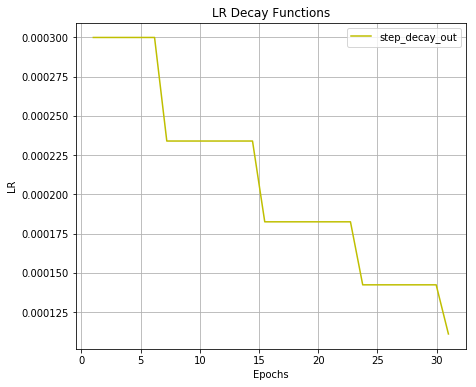

In [29]:
#https://research.fb.com/wp-content/uploads/2017/06/imagenet1kin1h5.pdf?

max_epochs = H.NUM_EPOCHS

epts = np.linspace(1, max_epochs+1, max_epochs)

step_decay_out = np.vectorize(step_decay)(epts) * H.LR

plt.figure(figsize=(7,6))

plt.plot(epts,step_decay_out, label='step_decay_out', color='y')

plt.title("LR Decay Functions")
plt.xlabel("Epochs");
plt.ylabel("LR");
plt.grid(True)
plt.legend(loc='upper right');

In [30]:
m = Metric([('train_loss', np.inf), ('valid_loss', np.inf), ('valid_ppl', np.inf), ('valid_score', 0),
            ('train_lr', 0) ])

epoch_itr = tqdm_notebook(range(1, H.NUM_EPOCHS+1))

for epoch in epoch_itr:
    epoch_itr.set_description('Epoch')

    nhtr.train(True)

    scheduler.step(epoch)
    
    m.train_lr = [float(param_group['lr']) for param_group in optimizer.param_groups][0]
    
    avg_loss = 0.0

    for idx_batch,(input_variables, target_variables,_) in enumerate(train_loader):
        input_variables, target_variables = Variable(input_variables), Variable(target_variables)
        if H.USE_CUDA:
            input_variables, target_variables = input_variables.cuda(), target_variables.cuda()

        decoder_outputs = nhtr(input_variables, target_variables)
        
        loss = 0
        target_length = target_variables.size(1) - 1
        for idx_seq in range(target_length):
            seq_output = decoder_outputs[idx_seq]
            out_batch_size = target_variables.size(0)                        
            loss += criterion(seq_output.contiguous().view(out_batch_size, -1), target_variables[:, idx_seq + 1])
        
        avg_loss += loss.item() / (idx_seq + 1)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(nhtr.parameters(), H.MAX_GRAD_NORM)
        optimizer.step()
        
        if not idx_batch % 50:
            epoch_itr.set_postfix(epoch="{0:d}".format(epoch), batch="{0:d}".format(idx_batch),
                          train_loss="{0:.4f}".format(m.train_loss), valid_loss="{0:.4f}".format(m.valid_loss),
                          valid_ppl="{0:.4f}".format(m.valid_ppl), valid_score="{0:.4f}".format(m.valid_score),
                          lr=m.train_lr, 
                          best_score="{0:d}/{1:.4f}".format(stopping.best_score_epoch, stopping.best_score))  

    m.train_loss = avg_loss / (idx_batch + 1)
    
    nhtr.eval()   # Turn on evaluation mode which disables dropout and teacher_forcing.
    with torch.no_grad():
        
        avg_loss = 0.0
        avg_score = 0.0
        for idx_batch,(input_variables, target_variables,_) in enumerate(valid_loader):
            input_variables, target_variables = Variable(input_variables), Variable(target_variables)
            if H.USE_CUDA:
                input_variables, target_variables = input_variables.cuda(), target_variables.cuda()

            decoder_outputs = nhtr(input_variables, None)
            batch_size = target_variables.size(0)
            max_len = target_variables.size()[1]

            loss = 0
            score = 0
            target_length = target_variables.size(1) - 1
            for idx_seq in range(target_length):
                seq_output = decoder_outputs[idx_seq]
                loss += criterion(seq_output.contiguous(), target_variables[:, idx_seq + 1])
                        
            avg_loss += loss.item() / (idx_seq + 1)
            avg_score += accuracy_score(decoder_outputs, target_variables)
            
        m.valid_loss = avg_loss / (idx_batch + 1)
        m.valid_ppl = get_perplexity(m.valid_loss)
        m.valid_score = avg_score / (idx_batch + 1)

    epoch_itr.set_postfix(epoch="{0:d}".format(epoch), batch="{0:d}".format(0),
                          train_loss="{0:.4f}".format(m.train_loss), valid_loss="{0:.4f}".format(m.valid_loss),
                          valid_ppl="{0:.4f}".format(m.valid_ppl), valid_score="{0:.4f}".format(m.valid_score),
                          lr=m.train_lr, 
                          best_score="{0:d}/{1:.4f}".format(stopping.best_score_epoch, stopping.best_score))  
    
    if stopping.step(epoch, m.valid_score):
        print("Early stopping at epoch: %d, score %f" % (stopping.best_score_epoch, stopping.best_score))
        break


HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

In [31]:
print("Best epoch: %d, score %f" % (stopping.best_score_epoch, stopping.best_score))

Best epoch: 30, score 0.783777


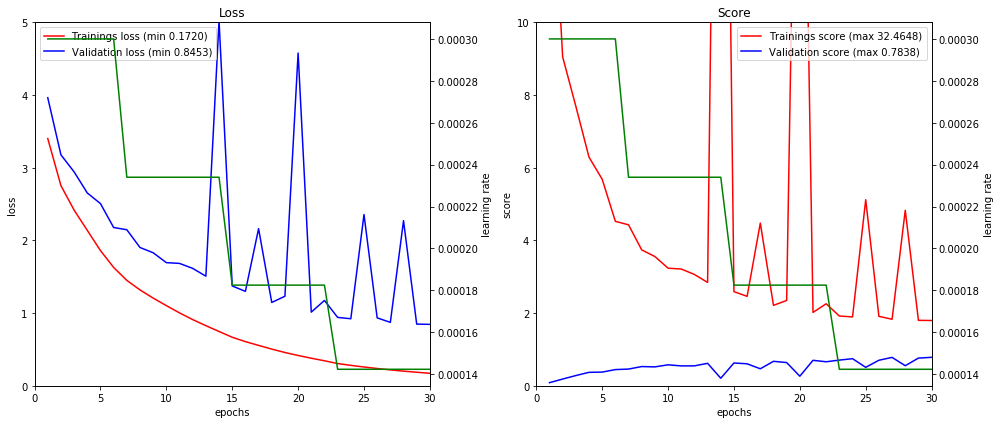

In [32]:
plot_learning_curves(m, loss_ylim=(0, 5.0), score_ylim=(0.0, 10.0), figsize=(14,6))

In [33]:
nhtr.load_state_dict(stopping.best_score_state)

torch.save(nhtr.state_dict(), "NTR_attention_stn.tar")

In [34]:
nhtr.eval()   # Turn on evaluation mode which disables dropout and teacher_forcing.
with torch.no_grad():

    avg_loss = 0.0
    avg_score = 0.0
    for idx_batch,(input_variables, target_variables, _) in enumerate(test_loader):
        input_variables, target_variables = Variable(input_variables), Variable(target_variables)
        if H.USE_CUDA:
            input_variables, target_variables = input_variables.cuda(), target_variables.cuda()

        decoder_outputs = nhtr(input_variables, None)

        batch_size = target_variables.size(0)
        max_len = target_variables.size()[1]

        loss = 0
        score = 0
        target_length = target_variables.size(1) - 1
        for idx_seq in range(target_length):
            seq_output = decoder_outputs[idx_seq]
            loss += criterion(seq_output.contiguous(), target_variables[:, idx_seq + 1])
                                    
        avg_loss += loss.item() / (idx_seq + 1)
        avg_score += accuracy_score(decoder_outputs, target_variables)

print("Loss: ", avg_loss / (idx_batch + 1))
print("Score: ", avg_score / (idx_batch + 1))

Loss:  1.0428438420042594
Score:  0.7019208037825059


In [35]:
encoder = Encoder(H.HIDDEN_SIZE, n_layers=H.NUM_RNN_LAYERS, dropout=H.DROPOUT)
decoder = Decoder(OUTPUT_VOCAB_SIZE, H.HIDDEN_SIZE, OUTPUT_VOCAB_SIZE, n_layers=H.NUM_RNN_LAYERS, dropout=H.DROPOUT)
nhtr_pred = NeuralHandwrittenTextRecognition(encoder, decoder, teacher_forcing_ratio=0.5, seq_max_len=MAX_SEQ_LEN)
if H.USE_CUDA:
    nhtr_pred.cuda()

state = torch.load("NTR_attention_stn.tar")
nhtr_pred.load_state_dict(state)

In [36]:
image, target, _ = next(train_loader.__iter__())
image = Variable(image)
if H.USE_CUDA:
    image = image.cuda()
    
image = image[0:1]
image.shape

torch.Size([1, 3, 48, 512])

In [37]:
nhtr_pred.eval()   # Turn on evaluation mode which disables dropout and teacher_forcing.
with torch.no_grad():
    batch_size = image.size(0)
    
    decoder_outputs = nhtr_pred(image, None)
    
    output_seq = []
    for decoder_output in decoder_outputs:
        for batch_idx in range(batch_size):
            output_seq.append(decoder_output[batch_idx].topk(1)[1].item())

#     output_seq = eos_parsing(output_seq)
    output_seq = torch.LongTensor(output_seq)

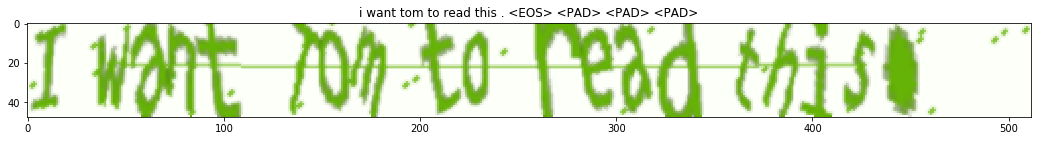

In [38]:
visualize_data(dataset, image[0], output_seq)

In [39]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(idx=(0,10))
def show(idx):
    image, target, _ = next(test_loader.__iter__())
    image = Variable(image)
    if H.USE_CUDA:
        image = image.cuda()

    image = image[0:1]
    image.shape

    nhtr_pred.eval()   # Turn on evaluation mode which disables dropout and teacher_forcing.
    with torch.no_grad():
        batch_size = image.size(0)

        decoder_outputs = nhtr_pred(image, None)

        output_seq = []
        for decoder_output in decoder_outputs:
            for batch_idx in range(batch_size):
                output_seq.append(decoder_output[batch_idx].topk(1)[1].item())

    #     output_seq = eos_parsing(output_seq)
        output_seq = torch.LongTensor(output_seq)
    
    
    visualize_data(dataset, image[0], output_seq)

interactive(children=(IntSlider(value=5, description='idx', max=10), Output()), _dom_classes=('widget-interact',))